Karina Chiñas Fuentes | 01/03/23

Notes based on the document [Impact of scaling laws on tokamak reactor dimensioning, 2019](https://hal-cea.archives-ouvertes.fr/cea-02378299/document)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants as spc

import warnings

from scipy import optimize, odr
from scipy.optimize import fsolve

qe = spc.elementary_charge # C
μ0 = spc.mu_0 # H/m

pd.set_option('display.max_columns', None)

From scaling law and other replacements, one can find a relationship that couples the outer radius of the TOKAMAK $R$ to the toroidal magnetic field $B$. I will refer to this relationship as the design equation, since it is widely used when designing TOKAMAKS. The design equation takes the form of

$$
    R^{-\gamma_R}\cdot B^{-\gamma_B} = \left[{\gamma_{rad}\cdot\left( \frac{1}{\lambda} + \frac{1}{Q} \right)}\right]^{\alpha_p+1}\cdot\frac{C^{\alpha_n}_{n}C^{\gamma_I}_{I}C_{fus}}{C_\beta C_{tr}}\cdot \alpha_0\cdot\hat{P}^{\alpha_P}_{fus}\cdot M^{\alpha_M}_{eff}\cdot \kappa^{\alpha_\kappa}\cdot \epsilon^{\gamma_\epsilon}\cdot n_N^{\alpha_n}\cdot q^{-\gamma_I} \cdot \beta_N
$$


With

* $\gamma_{rad}$ being the coefficient that parametrizes the total radiative losses in terms of the power heating sources; namely
    $$
        P_{rad} = (1 - \gamma_{rad})P_{scs}, \:\: \text{with}\:\: 0\leq \gamma_{rad} \leq 1
    $$
* $\gamma_I = 1+\alpha_n+\alpha_I$ 
* $\gamma_\epsilon = 1 + \alpha_\epsilon + 2\alpha_I$
* $\gamma_R = \alpha_R + \alpha_I - \alpha_n$
* $\gamma_B = \alpha_B + \alpha_n + \alpha_I + 2$

and constants

* $C_n = 10/\pi \approx 3.1831$
* $C_{tr} = 6\pi^2\cdot10^{19}\cdot10^{-3}\cdot e \approx 0.095$
* $C_I = \mu_0^{-1}2\pi F\cdot10^{-6}$; with F being a plasma shape parameter: $F=\sqrt{ (1+\kappa^2)/2 }$
* $C_\beta = 4\cdot10^{2}\cdot\mu_0\cdot10^{19}\cdot10^3\cdot e \approx 0.805$
* $C_{fus} = E_{fus-particles}\cdot e \cdot$ CONST $\cdot10^{2\cdot19}\cdot\pi^2/2$
    - $E_{fus-particles}$ is the total energy released per fusion reaction. z.B.: DT: $E_{DT} = 17.59$ MeV 
    - **CONST** is a reference on how the reactivity $<\sigma\nu>$ relates to the temperature. If one considers the following plot:
    <img src="REACTIVITYvsTEMP.png" width="350">
    One can get to the relation that
    $$
        <\sigma\nu>_{DT}\:\: \approx 1.1810^{-24}\cdot\hat{T}^2[m^3s^{-1}]
    $$
    Which suggests a range of values for the Temperature of: 10.3 keV to 18.5 keV. One should also consider that the Lawson Criterion is fulfilled. Thus, for the DT case: $C_{fus} \approx 1.6410^{-3}$. By using DT, this would also set $\gamma = 4.94$, since $\gamma = E_{fus-particles}/E_{heating-particle}$; so that, for DT: $E_{DT} / E_{\alpha - DT} = 17.59$ MeV / $3.56$ MeV.  


### Considering Instabilities and Limiting cases:

* Greenwald Limit: $n_N \sim 0.85$
* Normalized Beta Limit: $\beta_N < g$
    - Troyon Limit `g <- 2.8`
    
For simplifying the expression, I will set the following variables:

$$
    \Gamma(Q) =  \left[\gamma_{rad}\cdot\left( \frac{1}{\lambda} + \frac{1}{Q} \right)\right]^{\alpha_p+1}
$$

and 

$$
    C = \frac{C^{\alpha_n}_{n}C^{\gamma_I}_{I}C_{fus}}{C_\beta C_{tr}}
$$

So that the design equation takes the form of:

$$
    R^{-\gamma_R}\cdot B^{-\gamma_B} = C\cdot \Gamma(Q) \cdot \alpha_0\cdot\hat{P}^{\alpha_P}_{fus}\cdot M^{\alpha_M}_{eff}\cdot \kappa^{\alpha_\kappa}\cdot \epsilon^{\gamma_\epsilon}\cdot n_N^{\alpha_n}\cdot \beta_N
$$

What follows is the analysis of how these parameters influence the toroidal magnetic field and the outer radius. Furthermore, it is possible to consider the following relation which comes from expressing the fusion power in terms of the normalized plasma beta. This leads to:

$$
    R^3B^4 = \frac{\hat{P}_{fus} C^2_{\beta}q^2 }{C_{fus}C^2_I\kappa\epsilon^4\beta^2_N}
$$

This can help to decouple the design equation. One can also take into consideration the technological limits, like maximum B-field provided by superconductors, and economical considerations. 

In [3]:
# GIVEN P_fus, Q

P_fus = 500 # Fusion Power [MW]
Q = 10      # Fusion Gain

In [4]:
# TOKAMAK CHARACTERISTICS -- ITER LIKE VALUES

q = 3         # safety factor
ε = 3.1**-1   # inverse aspect ratio
κ = 1.7       # elongation
δ = 0.33      # triangularity
n_N = 0.85    # Greenwald limit -- factor
M_eff = 2.554 # Effective mass
γ_rad = 0.7   # parametrization factor

# REFINED PHYSICS

θi = 1/1.15
fα = 0.035
fp = 1.35

In [5]:
F = np.sqrt( (1+κ**2)/2 ) # Factor due to the shape of plasma

E_fus_prtcls = 17.59      # total energy released in DT fusion event [MeV]
E_α = 3.56                # energy released by the alpha-particles
λ = E_fus_prtcls/E_α
react_σ = 1.18e-24        # Reactivity CONST of DT

In [6]:
DB2P8 = pd.read_csv( "data/DB2P8_regression_coefficients.csv" ) # Database 1998 -- version 2.8
DB5   = pd.read_csv( "data/DB5_regression_coefficients.csv" )   # Database 2021 -- version 2.3

paper = pd.read_csv( "data/paper_regression_coefficients.csv" )

scaling_law_params = paper.values[0]

[DB5 DATABASE](https://dataspace.princeton.edu/handle/88435/dsp01m900nx49h)

In [7]:
def get_phys_constants(F, E_fus_prtcls, react_σ):
    Cn = 10/np.pi
    C_tr = 6*np.pi*np.pi*(1e19)*(1e-3)*qe 
    #CI = (1/μ0)*2*np.pi*F*1e-6
    Cβ = 4*1e2*μ0*1e19*1e3*qe
    C_fus = E_fus_prtcls * qe * react_σ * ((1e19)**2) * ((np.pi**2)/2)
    
    # With refined physics
    
    C_fus = C_fus*(( 1-2*fα )**2)*θi*θi*fp
    C_tr  = C_tr*(1 + θi - fα*θi)/2
    Cβ    = Cβ*(1 + θi - fα*θi)/2
    
    # Considering Triangularity
    
    CI = (2*np.pi*1e-6/μ0)*( (1.17 - 0.65*ε)/(2*((1-ε*ε)**2)) )*( 1+κ*κ*( 1+2*(δ**2)-1.2*(δ**3) ) ) 
    
    return Cβ, CI, Cn, C_fus, C_tr

#### Refined Physics | Accounting for $\alpha$-particle dilution, temperature peaking and different ion and electron temperatures

* $f_\alpha = n_{He}/n_e$: the fraction of $\alpha$-particles that depend on pumping efficiency and particle transport.
* $f_p = <T^2>/<T>^2$ the assumption of parabolic shape for temperatures. 
* $\theta_i = T_i/T_e$ the ratio of ion to electron temperatures. It's expected that $\theta_i<1$.

Thus, 

* $C_{fus} \rightarrow C_{fus}\cdot(1-2f_\alpha)^2\theta^2_i\cdot f_p$
* $C_{tr}  \rightarrow C_{tr}\cdot(1+\theta_i - f_\alpha\theta_i)/2$
* $C_\beta \rightarrow C_\beta\cdot(1+\theta_i - f_\alpha\theta_i)/2 $


Considering Triangularity

* $C_I = \frac{2\pi10^{-6}\left( 1.17 - 0.65\epsilon \right)}{\mu_02\left(1-\epsilon^2\right)^2}\cdot\left[ 1 + \kappa^2(1+2\delta^2 - 1.2\delta^3) \right]$

In [8]:
def design_eq(P_fus, Q, βN, scaling_law_params):
    α0, αI, αB, αn, αP, αR, ακ, αε, αM = scaling_law_params
    Cβ, CI, Cn, C_fus, C_tr  = get_phys_constants(F, E_fus_prtcls, react_σ)
    
    γI = 1 + αn + αI
    γε = 1 + αε + 2*αI
    γR = αR + αI - αn
    γB = αB + αn + αI + 2
    
    Γ = ( γ_rad*(1/λ + 1/Q) )**( αP + 1 )
    C = ( (Cn**αn) * (CI**γI) * C_fus )  /  (Cβ * C_tr) 
    
    RB_gammas = C * Γ * α0 * (P_fus**αP) * (M_eff**αM) * (κ**ακ) * (ε**γε) * (q**-γI) * (n_N**αn) * βN
    
    return γR, γB, RB_gammas

In [9]:
def fusion_power_eq(P_fus, βN):
    Cβ, CI, Cn, C_fus, C_tr  = get_phys_constants(F, E_fus_prtcls, react_σ)
    RB_fusion_power = ( (P_fus * (Cβ*q)**2 ) / ( C_fus*(CI**2)*κ*(ε**4)*(βN**2) ) ) 
    return RB_fusion_power

In [10]:
def solve_RB(βN, initial_roots = [3,3]):
    def func_solver(x):
        γR, γB, RB_gammas = design_eq(P_fus, Q, βN, scaling_law_params)
        RB_fusion_power = fusion_power_eq(P_fus, βN)
        return (
            RB_gammas - (x[0]**-γR)*(x[1]**-γB),
            RB_fusion_power - (x[0]**3)*(x[1]**4)
        )
    warnings.filterwarnings("ignore")
    roots = optimize.root(func_solver, initial_roots, 
                      method='lm', 
                      options={
                          "maxiter":int(1e6),
                          "ftol":1e-5,
                      })
    warnings.filterwarnings("always")
    if roots["success"] == False:
        warnings.warn(f"WARNING: solver requires tuning, for βN = {βN}")
    return roots.x

In [11]:
βN = np.linspace(1.5, 2.07, 500)
cost_of_machine = lambda r,b: (b**2)*(r**3)

roots = [0]*len(βN)
for i, beta in enumerate(βN):
    roots[i] = solve_RB(beta)

* H-Mode: $\beta_N \in [1.9, 2.1]$
* L-Mode: $\beta_N \in [0.4, 0.6]$

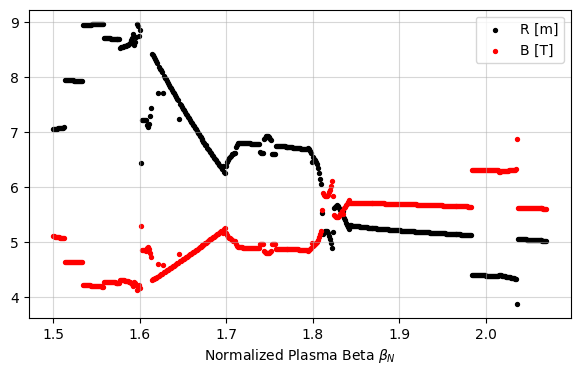

In [12]:
plt.figure(figsize=(7,4))

roots = pd.DataFrame(roots, columns=["R","B"])
plt.scatter(βN, roots.R, label = "R [m]" , s=8, c="k")
plt.scatter(βN, roots.B, label = "B [T]", s=8, c="r")
plt.xlabel("Normalized Plasma Beta $\\beta_N$")
plt.grid(alpha=0.5)
plt.legend();

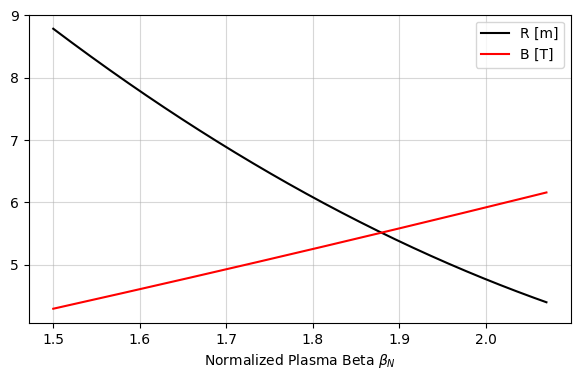

In [13]:
plt.figure(figsize=(7,4))

x, y = βN, roots.B
z = np.polyfit(x, y, 2)
p = np.poly1d(z)
Y_B = p(x)

x, y = βN, roots.R
z = np.polyfit(x, y, 2)
p = np.poly1d(z)
Y_R = p(x)

plt.plot(x,Y_R, label="R [m]", c="k")
plt.plot(x,Y_B, label="B [T]", c="r")
plt.xlabel("Normalized Plasma Beta $\\beta_N$")
plt.legend()
plt.grid(alpha=0.5);

#### Unfortunately the Python solver for non-linear equations is not so straight forward to use; thus, a comparison in made when using [Matlab](https://fr.mathworks.com/help/optim/ug/fsolve.html) solver.


Done with resulting high-$\beta$ constrained ELMy H-mode scaling expression for ITERH.DB3, in engineering variables. 

$$
    \tau^{ELMy}_{T,th} = 0.0365\cdot I^{0.97} \cdot B^{0.08} \cdot P^{-0.63} \cdot n^{0.41} \cdot M_{eff}^{0.20}\cdot R^{1.93}\cdot \epsilon^{0.23}\kappa^{0.67}
$$

In [14]:
matlab_sol = pd.read_csv("data/MATLAB_vals.csv", index_col=None)
matlab_sol.head()

,R,B,beta_n
0,8.786631,3.845981,1.90
1,8.471739,3.942345,1.91
2,8.169690,4.040601,1.92
3,7.879895,4.140776,1.93
4,7.601799,4.242898,1.94


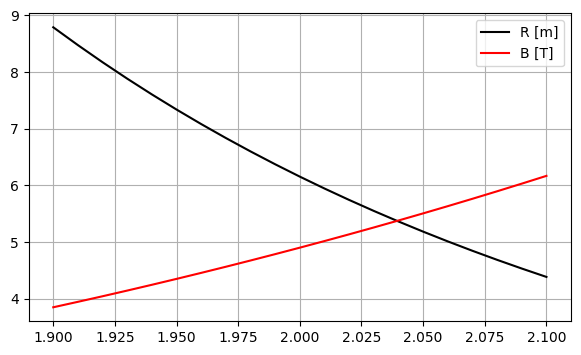

In [15]:
plt.figure(figsize=(7,4))
plt.plot(matlab_sol.beta_n, matlab_sol.R,label="R [m]", c="k")
plt.plot(matlab_sol.beta_n, matlab_sol.B,label="B [T]", c="r")
plt.grid()
plt.legend();

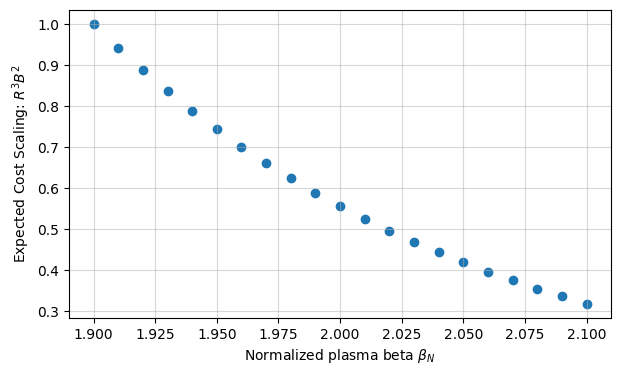

In [16]:
# Expected to cost with a scaling of ~ B^2R^3
plt.figure(figsize=(7,4))
RB_costs = (matlab_sol.B.values**2)*(matlab_sol.R.values**3)
max_RB_costs = max(RB_costs)
RB_costs = RB_costs/max_RB_costs
plt.scatter(matlab_sol.beta_n, RB_costs)
plt.grid(alpha=0.5)
plt.xlabel("Normalized plasma beta $\\beta_N$")
plt.ylabel("Expected Cost Scaling: $R^3B^2$");

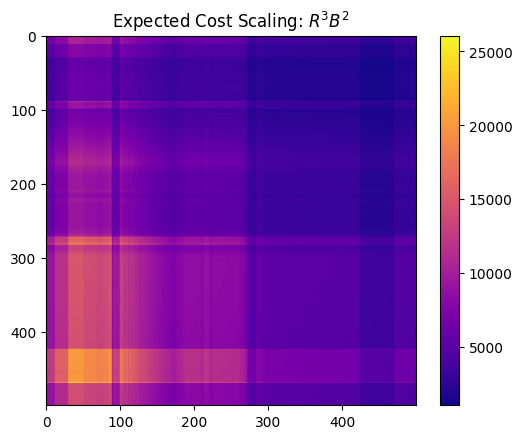

In [17]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(R,B):
    z = (R**2)*(B**3)
    return z
 
x = roots.R.values
y = roots.B.values
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,cmap=cm.plasma) # drawing the function
colorbar(im) # adding the colobar on the right
# latex fashion title
title("Expected Cost Scaling: $R^3B^2$")
show()

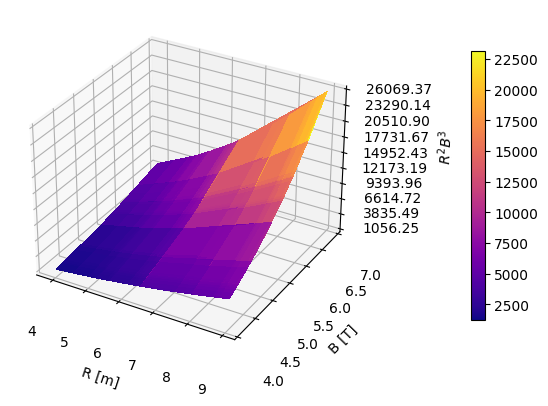

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.plasma,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.tick_params(axis='both', which='major', pad=15)

ax.set_xlabel('R [m]', labelpad=15)
ax.set_ylabel('B [T]', labelpad=15)
ax.set_zlabel('$R^2B^3$', labelpad=25)

fig.colorbar(surf, shrink=0.5, aspect=20, pad=0.2)

plt.show()